<font color='green' size='7'>**Промежуточная аттестация 2**</font>  
<font color='#11a642' size='6'>**Тема: Временные ряды**</font>  
<font size='5'>**Задание:**</font>  

Домашняя работа основана на лекции и семинаре по Временным рядам.

Данные для домашнего задания прикреплены в Дополнительных материалах.





**Описание плана работы**

1. Загрузка данных. Убедиться, что дата является индексом датасета.
2. Провести разведочный анализ данных (EDA).
3. Провести тест на стационарность ряда. Сделать вывод о стационарности.
4. Разделить данные на тестовую и тренировочную выборку.
5. Автоматически подобрать параметры для ряда с помощью auto_arima. Выбрать оптимальные значения.
7. Построить и обучить модель ARIMA, используя p,d,q из полученного результата по auto_arima. Построить прогноз для тестового набора данных. Оценить модель ARIMA.
8. Разложить на тренд и сезонность с помощью prophet. Оценить модель prophet
9. Сравнить модель ARIMA и prophet. Выбрать лучшую


# <font color='#11a642' size='6'> Импорт и установка библиотек



In [106]:
# установка дополнительной библиотеки
!pip install pmdarima

In [107]:
!pip install numpy==1.26.4

In [108]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd # работа с таблицами
import numpy as np # математические вычисления
from scipy import stats # статистические методы
import matplotlib
import matplotlib.pyplot as plt # визуализация данных
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller # тест Дики-Фуллера
from statsmodels.tsa.statespace.sarimax import SARIMAX # Построить модель SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima import auto_arima # автоматический подбор параметров.
from prophet import Prophet

# <font color='#11a642' size='6'> Загрузка данных


In [109]:
!gdown 1XFoZrWweyXM4kO9JWitNyAp50yySiMx_

Downloading...
From: https://drive.google.com/uc?id=1XFoZrWweyXM4kO9JWitNyAp50yySiMx_
To: /content/Electric_Production.csv
100% 7.32k/7.32k [00:00<00:00, 15.4MB/s]


In [110]:
try:
  df = pd.read_csv('Electric_Production.csv')
except:
  df = pd.read_csv('/content/Electric_Production.csv')

In [111]:
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


# <font color='#11a642' size='6'> Провести разведочный анализ данных (EDA)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [113]:
# Преобразование столбца 'DATE' в формат datetime
df['DATE'] = pd.to_datetime(df['DATE'])

In [114]:
# Установка 'Date' как индекса
df.set_index('DATE', inplace=True)

In [115]:
# Переименуем столбец "IPG2211A2N" в более понятное название
df = df.rename(columns={"IPG2211A2N": 'value'})

In [116]:
df.head()

,value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


- Анализ пропусков и выбросов


In [117]:
# Проверка на наличие пропусков
df.isna().sum()

,0
value,0


Как видим, пропуски в нашем датасете отсутствуют

# <font color='#11a642' size='6'> Провести анализ временного ряда

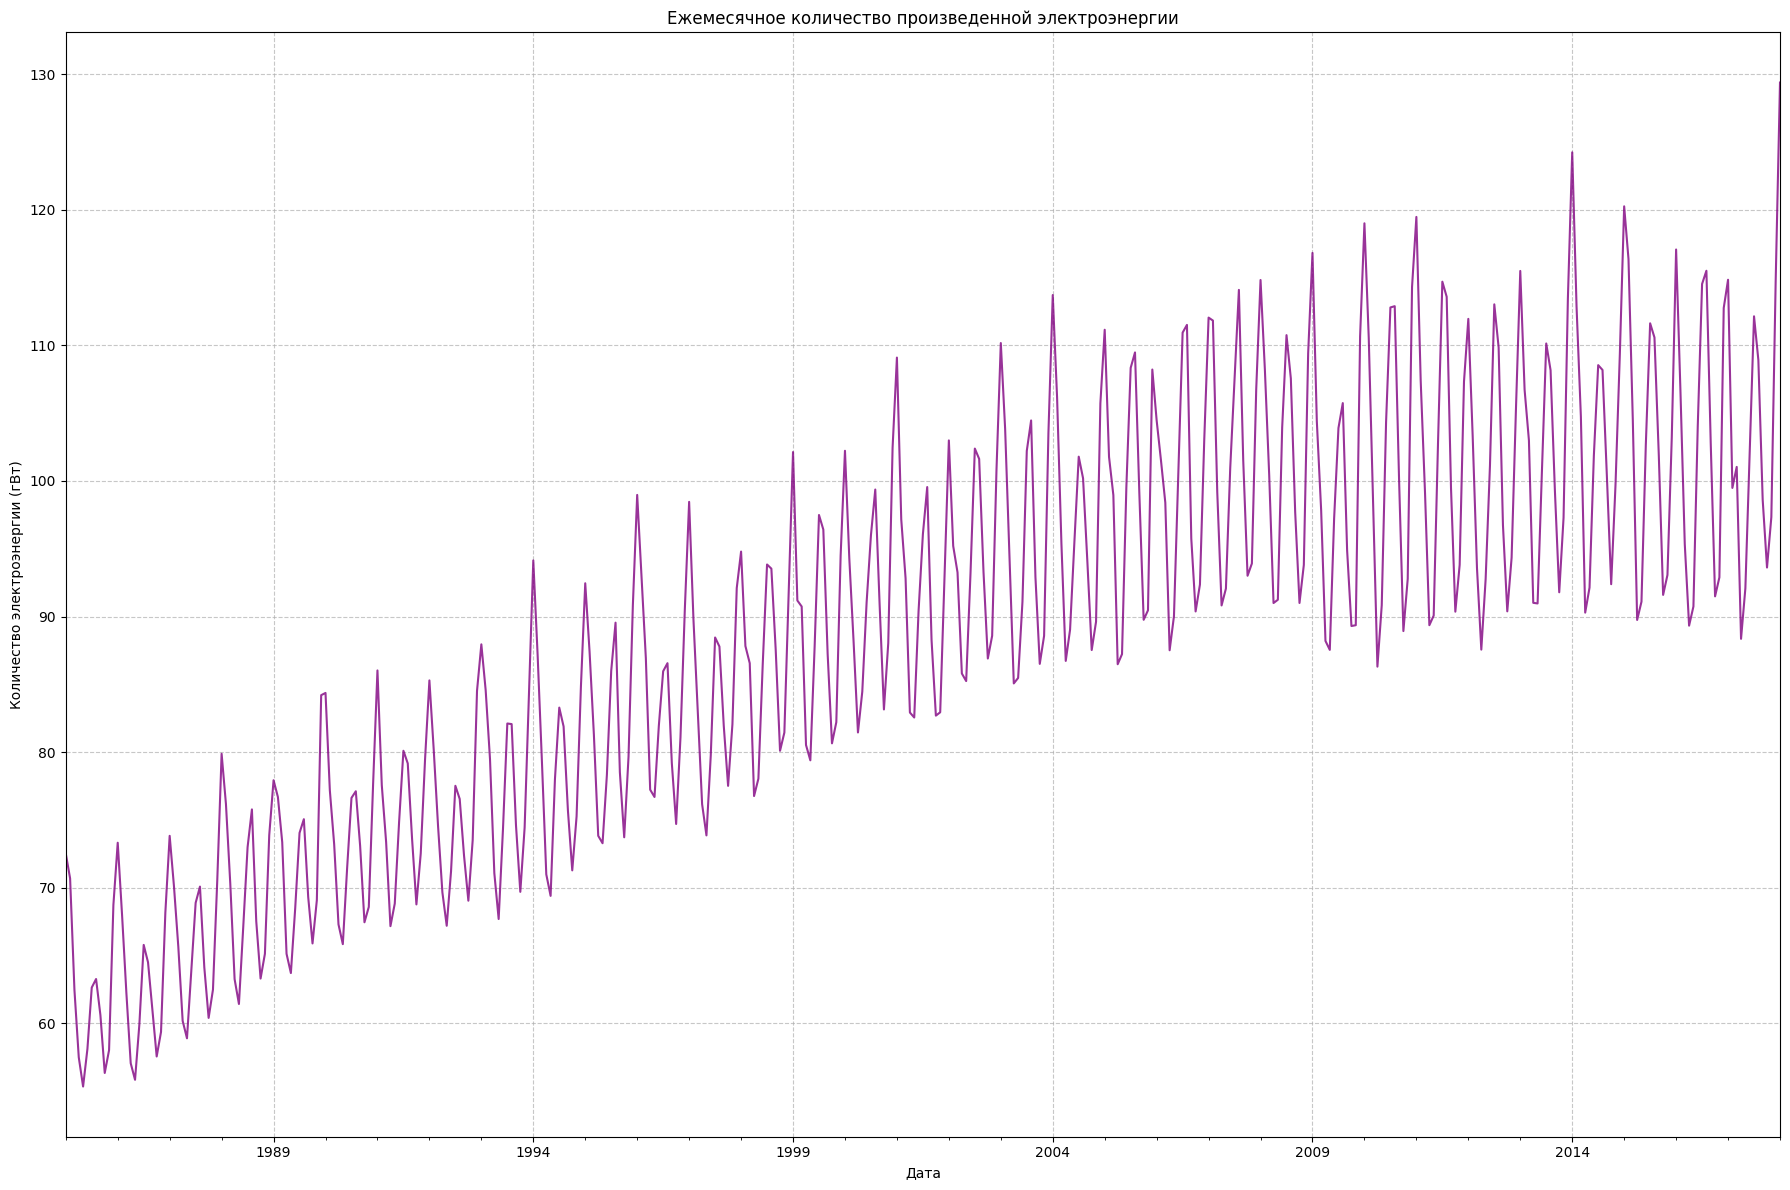

In [118]:
# Визуальный анализ компонентов временного ряда
plt.figure(figsize=(18, 12))


df['value'].plot(title='Ежемесячное количество произведенной электроэнергии', color='purple', alpha=0.8, linestyle='-')
plt.xlabel('Дата')
plt.ylabel('Количество электроэнергии (гВт)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Судя по графику, все значения укладываются в приемлемые рамки. Выбросы отсутствуют.
График показывает четкую годовую сезонность: увеличение производства электроэнергии зимой и уменьшение летом

Т.к. судя по графику, аплитуда колебаний примерно одинакова на протяжении всего ряда, то будем использовать аддитивную модель

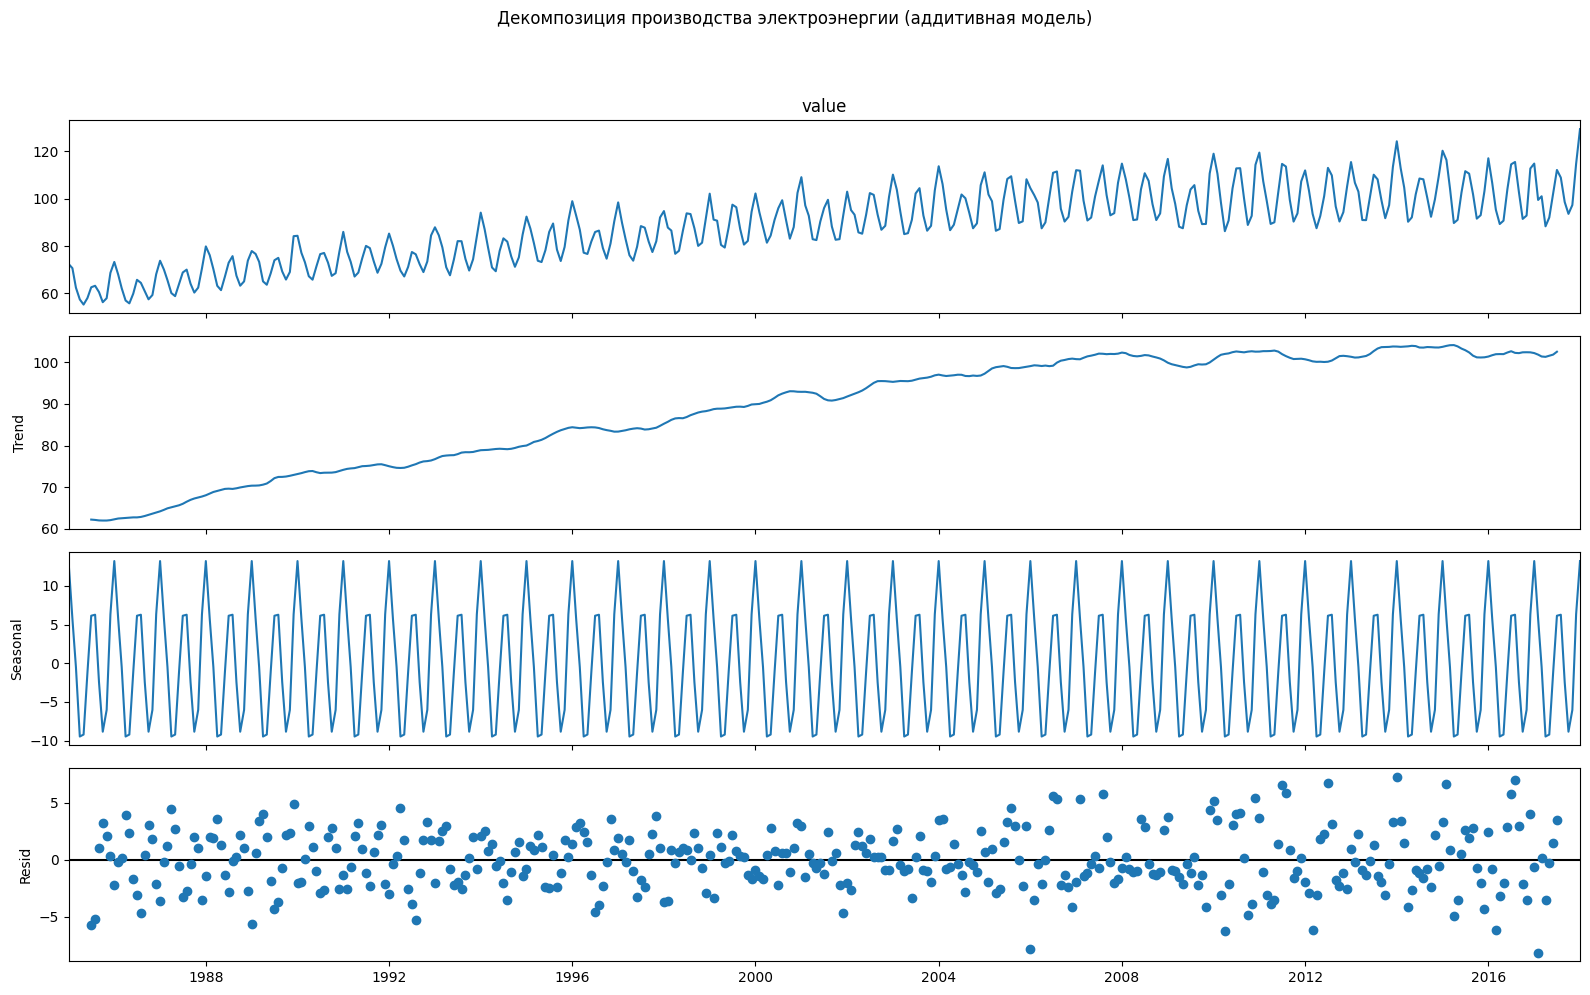

In [119]:
# Проведем декомпозицию временного ряда

decomposition_results_temp = seasonal_decompose(df['value'], model='additive', period=12)
fig_decomp = decomposition_results_temp.plot()
fig_decomp.set_size_inches(16, 10)
fig_decomp.suptitle('Декомпозиция производства электроэнергии (аддитивная модель)', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

# <font color='#11a642' size='6'> Разделить данные на тестовую и тренировочную выборку

Т.к. общее количество значений 397, то разделим данные: примерно 2/3 на тренировочную выбрку и 1/3 на тестовую

In [120]:
TEST_SIZE = 132
train= df.iloc[:len(df)-TEST_SIZE]
test= df.iloc[len(df)-TEST_SIZE:]

In [121]:
train

,value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2006-09-01,95.7632
2006-10-01,90.3738
2006-11-01,92.3566


In [122]:
test

,value
DATE,
2007-02-01,111.8399
2007-03-01,99.1925
2007-04-01,90.8177
2007-05-01,92.0587
2007-06-01,100.9676
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


## <font color='#11a642' size='5'>Автокорреляция и частичная автокорреляция

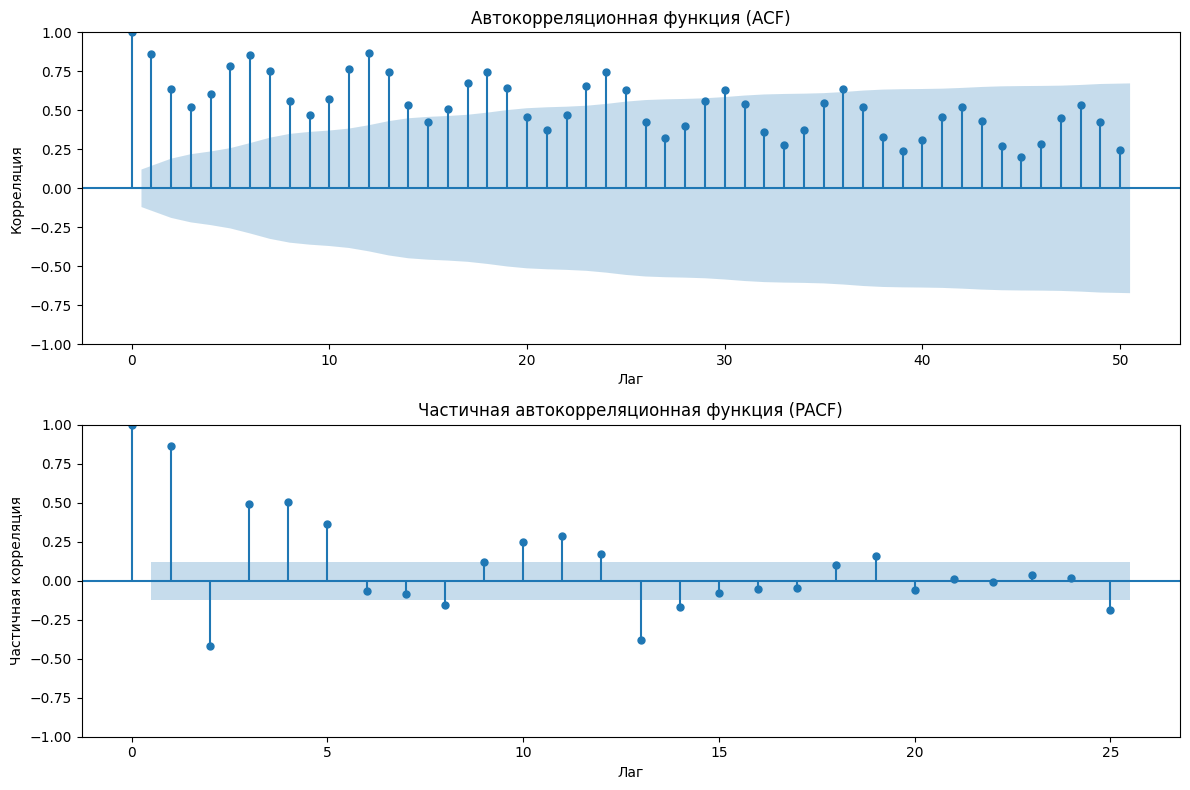

In [123]:
# Определяем количество лагов автоматически (но не более 50)
max_lags = min(50, len(train)-1)  # Обеспечиваем, чтобы лагов было меньше длины ряда

plt.figure(figsize=(12, 8))

# График ACF
plt.subplot(2, 1, 1)
plot_acf(train, lags=max_lags, ax=plt.gca(), alpha=0.05)  # Добавляем доверительный интервал 95%
plt.title('Автокорреляционная функция (ACF)')
plt.xlabel('Лаг')
plt.ylabel('Корреляция')

# График PACF
plt.subplot(2, 1, 2)
plot_pacf(train, lags=max_lags//2, ax=plt.gca(), alpha=0.05)
plt.title('Частичная автокорреляционная функция (PACF)')
plt.xlabel('Лаг')
plt.ylabel('Частичная корреляция')

plt.tight_layout()
plt.show()

# <font color='#11a642' size='6'> Провести тест на стационарность ряда

In [124]:
def adf_test(series,title=''):
  '''
  тест Дики-Фуллера
  0 гипотеза: ряд данных не стационарен
  альтернативная гипотеза: ряд данных стационарен
  Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда
  @param series - значения ряда
  @param title - заголовок ряда
  '''

  result = adfuller(series.dropna(),autolag='AIC')

  labels = ['ADF тест','p-value','# lags used','# наблюдения']
  out = pd.Series(result[0:4],index=labels)

  for key,val in result[4].items():
      out[f'критическое значение ({key})']=val

  print(out.to_string())

  if result[1] <= 0.05:
      print("Сильные доказательства против нулевой гипотезы")
      print("Отменяем 0 гипотезу")
      print("Данные стационарны")
  else:
      print("Слабые доказательства против нулевой гипотезы")
      print("Не отменяем 0 гипотезу")
      print("Данные не стационарны")

In [125]:
adf_test(df['value'])

ADF тест                       -2.256990
p-value                         0.186215
# lags used                    15.000000
# наблюдения                  381.000000
критическое значение (1%)      -3.447631
критическое значение (5%)      -2.869156
критическое значение (10%)     -2.570827
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


Сделать вывод о стационарности:

Ряд не стационарен (p-value > 0.05). Может потребоваться дифференцирование

# <font color='#11a642' size='6'> Модель SARIMA
Автоматически подобрать параметры для ряда с помощью auto_arima. Выбрать оптимальные значения

In [126]:
# найдем порядок p,d,q, сезонность P, D, Q
# ARIMA: обучение модели с сезонной составляющей
smodel = auto_arima(train,
                    start_p=0,
                    start_q=0,
                    max_p=7,
                    max_q=7,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1176.440, Time=1.26 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1261.937, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1140.221, Time=1.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1105.205, Time=1.79 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1339.803, Time=0.18 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1195.220, Time=0.53 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1107.110, Time=2.60 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1107.076, Time=3.29 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1146.249, Time=1.33 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=14.60 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1096.435, Time=0.94 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1187.126, Time=0.40 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1098.326, Time=0.89 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1098.271, Time=1.67 sec
 ARIMA(1,0,1)(1,1,0)[12

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  265
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -543.292
Date:                              Mon, 14 Jul 2025   AIC                           1094.584
Time:                                      20:23:54   BIC                           1108.718
Sample:                                  01-01-1985   HQIC                          1100.271
                                       - 01-01-2007                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8442      0.117      7.235      0.000       0.616       1.073
ar.L1          0.5306      0.056      9.502      0.000       0.421       0.640
ma.S.L12      -0.7173      0.055    -13.111      0.000      -0.825      -0.610
sigma2         4.1427      0.247     16.776      0.000       3.659       4.627
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               101.98
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               2.11   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ваш вывод (сравнить значения параметров):

auto_arima подобрала наилучшие параметры: order= (1,0,0), seasonal_order= (0,1,1,12)

In [127]:

# обучим модель
sarima_model= SARIMAX(train, order= (1,0,0), seasonal_order= (0,1,1,12))
sarima_model_fit= sarima_model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [128]:
# сделаем прогнозы на Test данных
start= len(train)
end= len(train) + len(test) -1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")


<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='DATE'>

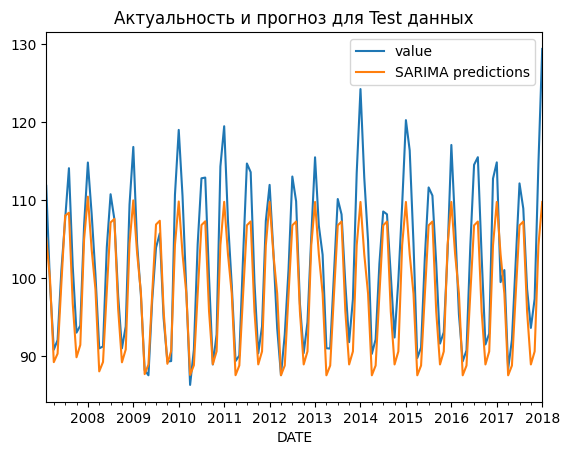

In [129]:
# построим прогноз
title= "Актуальность и прогноз для Test данных"
test.plot(title= title, legend=True)
pred.plot(legend=True)

In [130]:

# оценим модель
mse_sarima= mean_squared_error(test,pred)
mae_sarima= mean_absolute_error(test, pred)
mape_sarima = mean_absolute_percentage_error(test, pred)

print(f"MSE= {mse_sarima}")
print(f"MAE= {mae_sarima}")
print(f"MAPE= {mape_sarima}")

MSE= 26.16920751782866
MAE= 4.0361020483376295
MAPE= 0.03799508538696472


# <font color='#11a642' size='6'> Модель PROPHET

Для этой модели нужна специфическая настройка датасета. Столбец с датой должен называться 'ds', а столбец с данными 'y'.

In [131]:
df_prophet = df.reset_index().copy()[['DATE', 'value']]
df_prophet.columns = ['ds', 'y']
df_prophet.head()

,ds,y
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


Разделим данные на трейн и тест для этой модели в точно таких же пропорциях, как и для предыдущей модели

In [132]:
train_prophet = df_prophet[:-132]
test_prophet = df_prophet[-132:]

In [133]:
# Обучим модель
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05
)

model.fit(train_prophet)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpqku6pjdn/dny9_vtn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqku6pjdn/e0gmtoy9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40258', 'data', 'file=/tmp/tmpqku6pjdn/dny9_vtn.json', 'init=/tmp/tmpqku6pjdn/e0gmtoy9.json', 'output', 'file=/tmp/tmpqku6pjdn/prophet_model5jso80bp/prophet_model-20250714202355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [134]:
# сделаем прогнозы на Test данных
future = model.make_future_dataframe(periods=len(test_prophet), freq='MS')
forecast = model.predict(future)


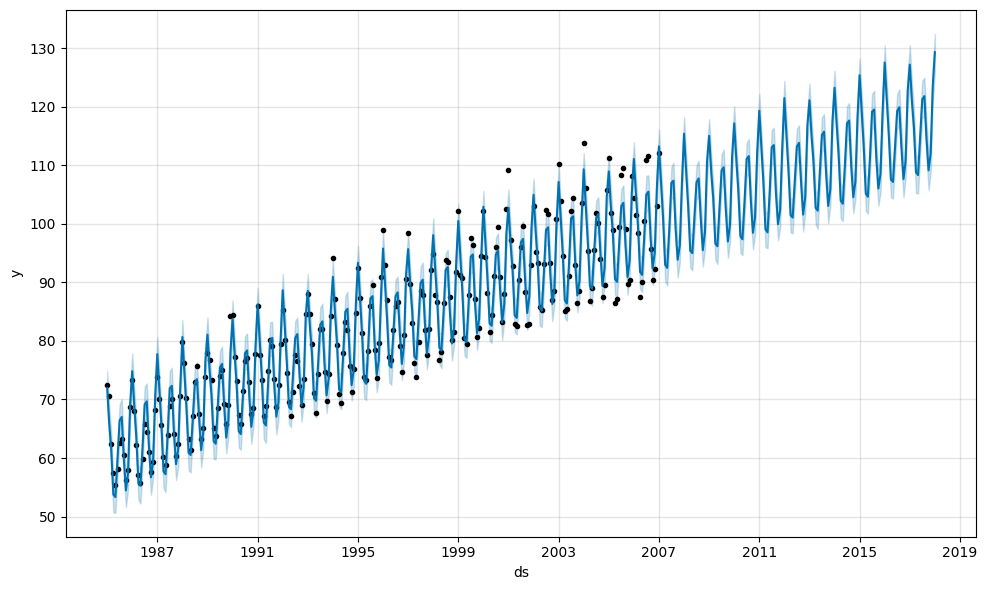

In [135]:
# Построим предсказанную модель
ax = model.plot(forecast)

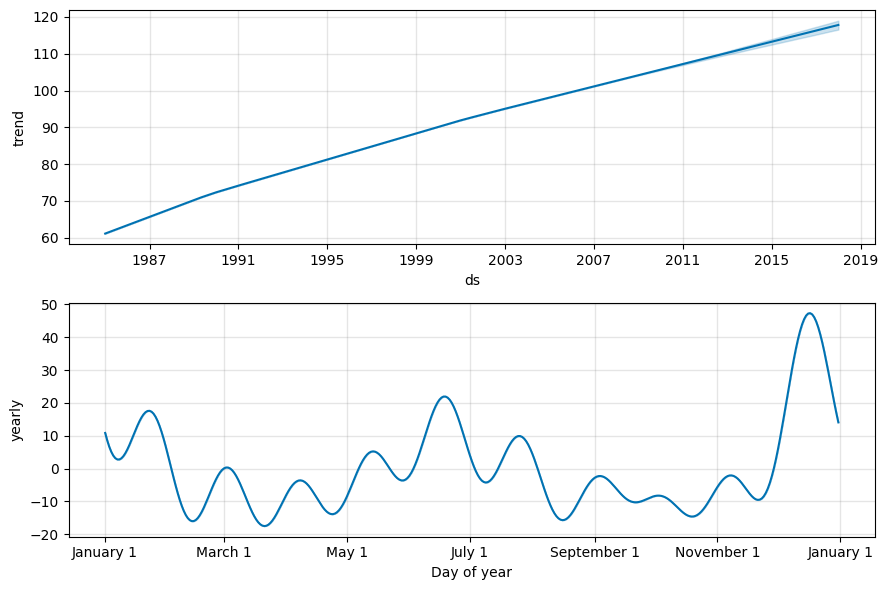

In [136]:
# Построим компонетны предсказанной модели
fig_components = model.plot_components(forecast)

In [137]:
p_prediction = test_prophet.set_index('ds').join(forecast.set_index('ds')[['yhat']])
p_prediction

,y,yhat
ds,,
2007-02-01,111.8399,106.929084
2007-03-01,99.1925,101.227996
2007-04-01,90.8177,93.011654
2007-05-01,92.0587,92.453444
2007-06-01,100.9676,99.159371
...,...,...
2017-09-01,98.6154,114.522325
2017-10-01,93.6137,109.117907
2017-11-01,97.3359,112.019589


In [138]:
# оценим модель
mse = mean_squared_error(p_prediction['y'], p_prediction['yhat'])
print('Prophet')
print('MSE:', mse)
print('MAE:', mean_absolute_error(p_prediction['y'], p_prediction['yhat']))
print('MAPE:', mean_absolute_percentage_error(p_prediction['y'], p_prediction['yhat']))

Prophet
MSE: 85.05131751925335
MAE: 7.677273001821429
MAPE: 0.07820654662726438


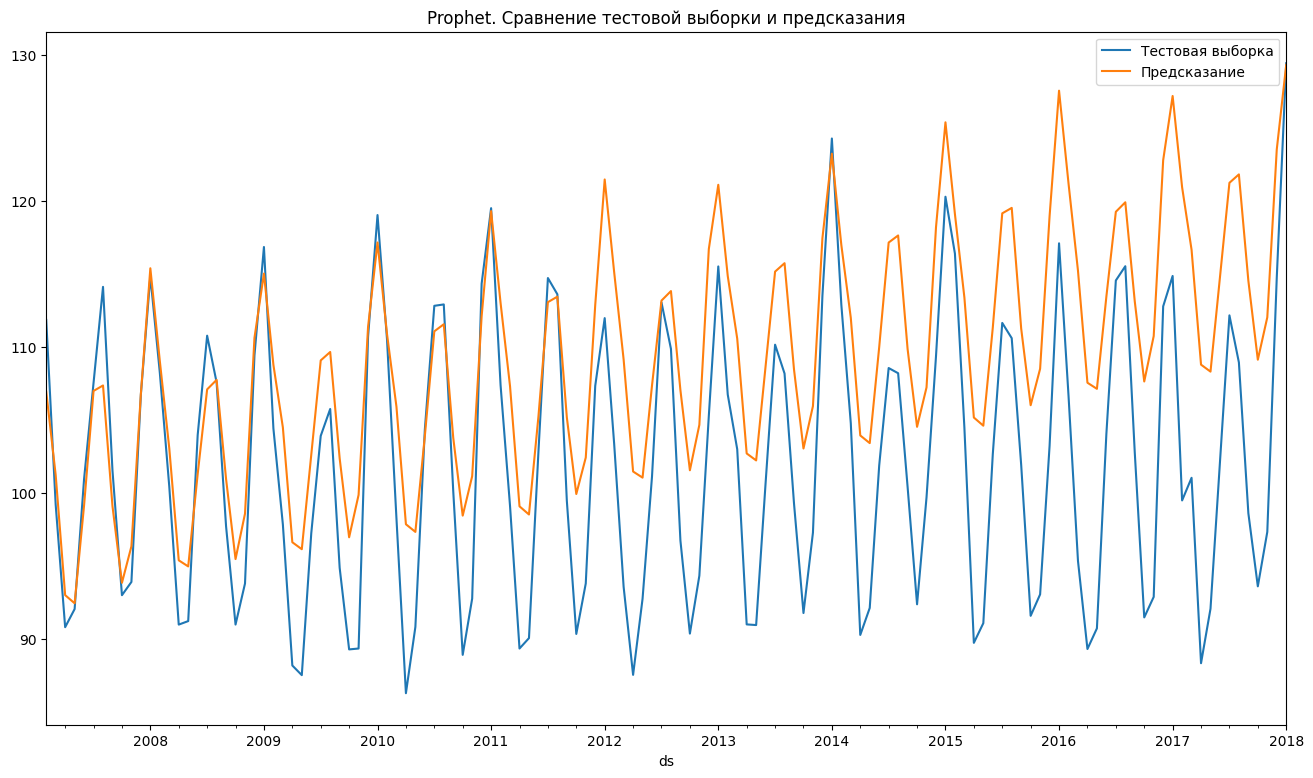

In [139]:
# Сравним тестовую выборку и предсказание
ax1 = p_prediction['y'].plot(legend=True, title='Prophet. Сравнение тестовой выборки и предсказания')
ax2 = p_prediction['yhat'].plot(figsize=(16,9), legend=True) \
  .legend(['Тестовая выборка', 'Предсказание'])

In [140]:
# Выведем метрики обеих моделей
# Метрики SARIMA
print('Метрики SARIMA:')
print(f"MSE= {mse_sarima}")
print(f"MAE= {mae_sarima}")
print(f"MAPE= {mape_sarima}")
print('=' * 50)

# Метрики Prophet
print('Метрики Prophet:')
print('MSE:', mse)
print('MAE:', mean_absolute_error(p_prediction['y'], p_prediction['yhat']))
print('MAPE:', mean_absolute_percentage_error(p_prediction['y'], p_prediction['yhat']))

Метрики SARIMA:
MSE= 26.16920751782866
MAE= 4.0361020483376295
MAPE= 0.03799508538696472
Метрики Prophet:
MSE: 85.05131751925335
MAE: 7.677273001821429
MAPE: 0.07820654662726438


Вывод:

Как видно из графиков, наилучшая модель - модель SARIMA, это также видно из метрик, полученных после обучения моделей. Метрики модели SARIMA лучше, чем метрики модели Prophet